In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

ModuleNotFoundError: No module named 'statsmodels'

In [15]:
!pip3 install statsmodels

Defaulting to user installation because normal site-packages is not writeable
  Using cached statsmodels-0.13.2-cp38-cp38-macosx_11_0_arm64.whl (9.1 MB)
  Using cached scipy-1.9.3.tar.gz (42.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [68 lines of output]
      The Meson build system
      Version: 0.63.3
      Source dir: /private/var/folders/0t/t63w8k9j7ns8xb4wgm79sy0c0000gn/T/pip-install-m44m7to_/scipy_e46191fe111f4860b988935306e9cea4
      Build dir: /private/var/folders/0t/t63w8k9j7ns8xb4wgm79sy0c0000gn/T/pip-install-m44m7to_/scipy_e46191fe111f4860b988935306e9cea4/.mesonpy-1c0cf7gl/build
      Build type: native build
      Project name: SciPy
      Project version: 1.9.3
      C compiler for the host machine: cc (clang 13.0.0 "Apple clang version 13.0.0 (clang-1300.0.29.3)")
      C linker for the host


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


### Обучаем по две модели для каждого склада
Одна для предсказания хранения, вторая - обработки

### Склад Урал - Хранение

In [11]:
import pickle
with open('dfs.pkl', 'rb') as f:
    dfs = pickle.load(f)
dfs['Урал']

,date,keeping_actual,keeping_reserved,processing_actual,receiving_actual,shipment_actual,processing_reserved
0,2018-01-01,1611.92,1500.0,0.00,0.00,0.00,800.0
1,2018-01-02,1611.92,1500.0,0.00,0.00,0.00,800.0
2,2018-01-03,1611.92,1500.0,0.00,0.00,0.00,800.0
3,2018-01-04,1611.92,1500.0,0.00,0.00,0.00,800.0
4,2018-01-05,1611.92,1500.0,0.00,0.00,0.00,800.0
...,...,...,...,...,...,...,...
1456,2021-12-27,4017.76,2600.0,222.80,181.47,41.33,900.0
1457,2021-12-28,4114.37,2600.0,161.97,137.93,24.03,900.0
1458,2021-12-29,4092.92,2600.0,59.48,2.59,56.89,900.0
1459,2021-12-30,4101.90,2600.0,94.48,68.60,25.89,900.0


In [67]:
dfs['СЗ']['keeping_actual'][1] = pd.to_numeric(dfs['СЗ']['keeping_actual'])

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [43]:
dfs['Урал']['keeping_actual']

0       1611.92
1       1611.92
2       1611.92
3       1611.92
4       1611.92
         ...   
1456    4017.76
1457    4114.37
1458    4092.92
1459    4101.90
1460    4076.01
Name: keeping_actual, Length: 1461, dtype: float64

In [44]:
dfs['Урал'].index = pd.to_datetime(dfs['Урал']['date'])

KeyError: 'date'

In [51]:
sd = seasonal_decompose(dfs['Урал']['receiving_actual'], model = 'additive', period = 160, extrapolate_trend = 'freq')

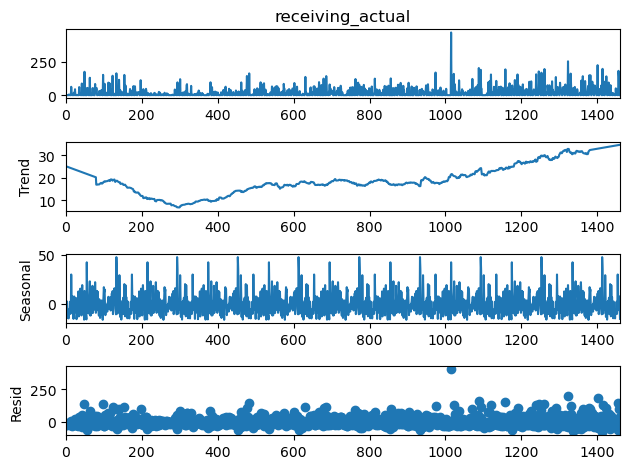

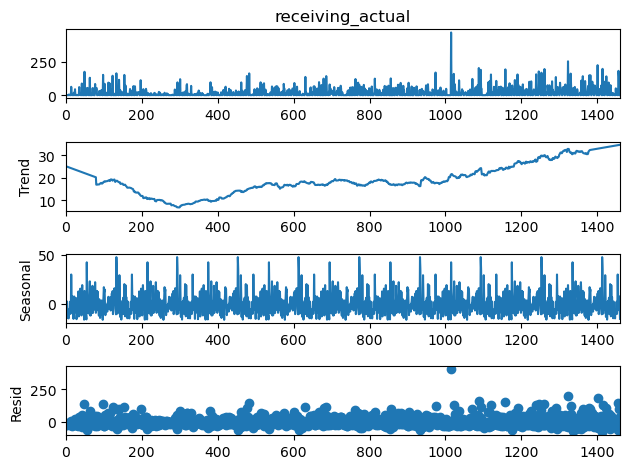

In [52]:
sd.plot()

In [13]:
from tsai.all import *
my_setup()

ModuleNotFoundError: No module named 'tsai'

In [5]:
target_col = "keeping_actual"

In [6]:
dfs['Урал'] = dfs['Урал'].drop(columns = ['date'])

In [7]:
list(dfs['Урал'].columns)

['keeping_actual',
 'keeping_reserved',
 'processing_actual',
 'receiving_actual',
 'shipment_actual',
 'processing_reserved']

In [8]:
feature_cols = list(dfs['Урал'].columns)
target_col_id = feature_cols.index(target_col)

In [9]:
data = dfs['Урал'].to_numpy()
wl = 160
horizon = 84
stride = 1
X, y = SlidingWindow(wl, horizon = horizon, stride=stride, get_y=[target_col_id], get_x = list(range(len(feature_cols))))(data)

In [10]:
len(X)

1218

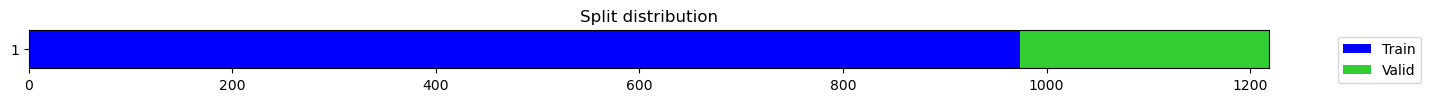

In [11]:
splits = TimeSplitter(valid_size = 0.2)(y)

epoch,train_loss,valid_loss,mape,_rmse,mae,time
0,5410493.500000,10492580.000000,0.999501,3239.225098,3220.254150,00:24
1,5341441.000000,10340518.000000,0.992675,3215.667480,3197.544678,00:24
2,5207038.000000,9608029.000000,0.957795,3099.682129,3083.612793,00:25
3,4967886.000000,9413158.000000,0.947106,3068.087158,3050.771973,00:24
4,4591310.000000,6567932.500000,0.793283,2562.797852,2551.093018,00:24
5,4066640.000000,6084790.500000,0.758565,2466.736816,2447.913086,00:24
6,3414652.000000,5732456.000000,0.745848,2394.254883,2384.063965,00:24
7,2711323.750000,2933887.000000,0.529263,1712.859253,1696.721558,00:24
8,2051990.375000,1228498.625000,0.305292,1108.376465,1017.920959,00:24
9,1516274.750000,3526964.500000,0.558738,1878.021606,1826.080078,00:25


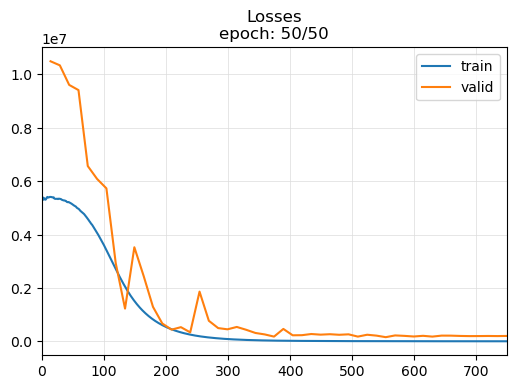

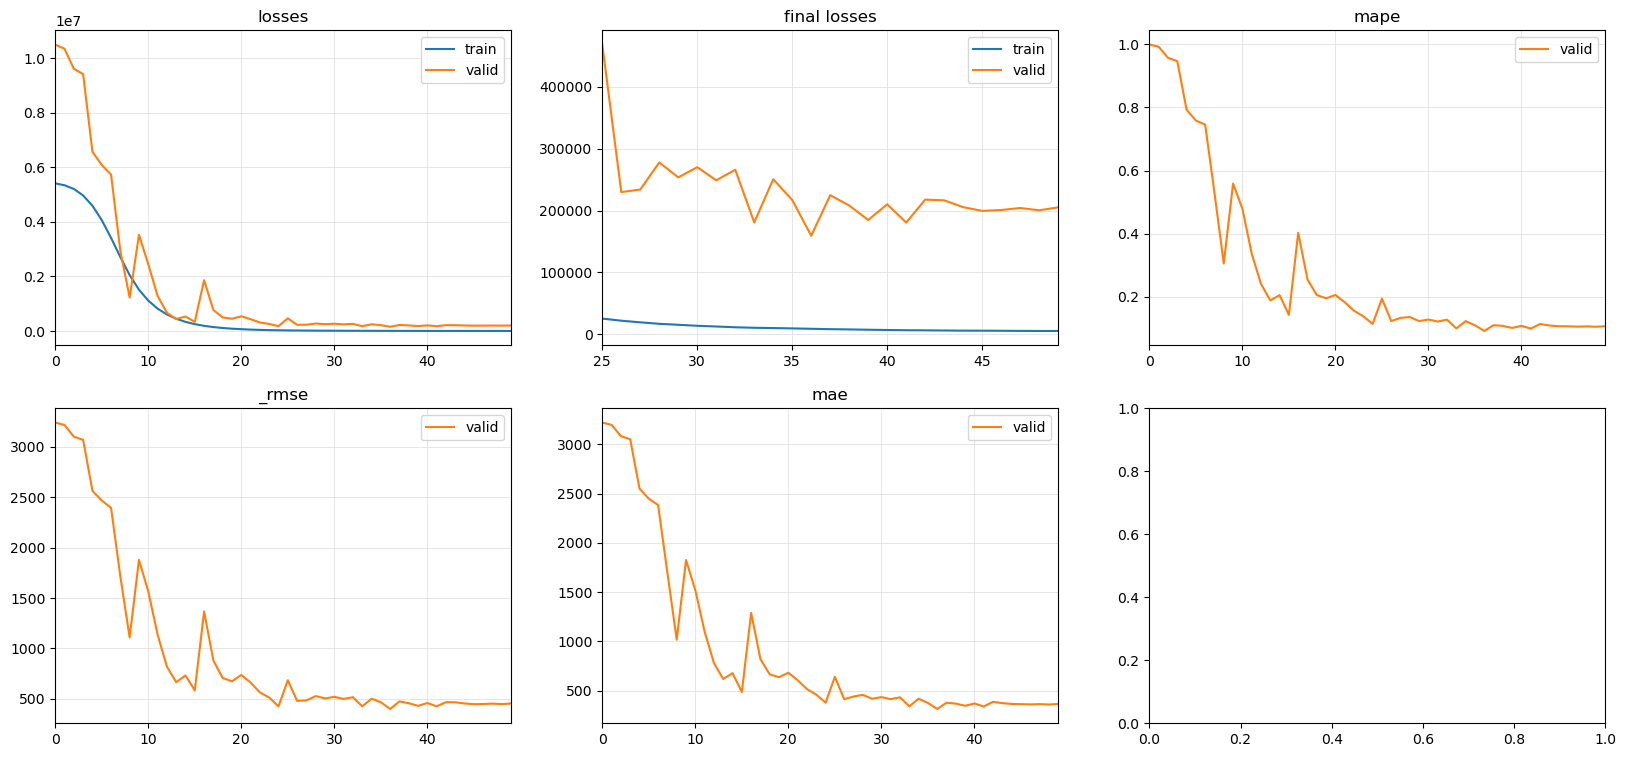

In [12]:
learn =  TSForecaster(X, y, arch_config = {'fc_dropout' : 0.5, 'nf' : 64},splits=splits, bs=[64, 128], batch_tfms=TSStandardize(by_sample=True), arch=InceptionTimePlus, cbs=ShowGraph(), metrics = [mape, rmse, mae])
learn.fit_one_cycle(50, 1e-3)

In [14]:
learn.save_all("/Users/tainella/Documents/MTC")

In [15]:
del learn

In [21]:
learn = load_learner("/Users/tainella/Documents/MTC/learner.pkl")

In [25]:
y_pred = learn.get_X_preds(X[splits[1]])

In [28]:
index_pred = 1
y_pred = learn.get_X_preds(np.array([X[splits[1]][index_pred]]))

In [29]:
y_gt = y[splits[1]][index_pred]

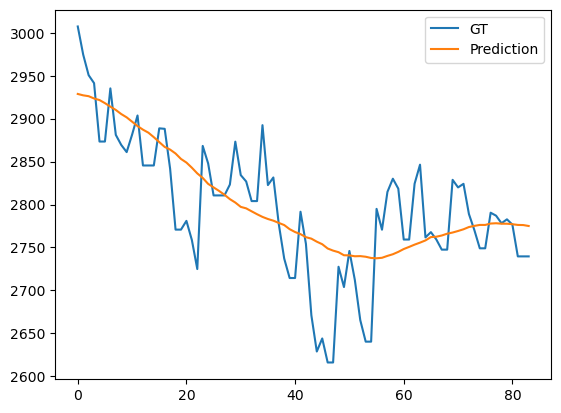

In [41]:
plt.plot(y_gt, label = "GT")
plt.plot(y_pred[0][0], label = "Prediction")
plt.legend()

In [37]:
y_pred[0][0]

TensorBase([2928.7617, 2927.1484, 2926.1711, 2923.4819, 2921.6677, 2918.0547,
            2913.9819, 2910.1416, 2905.3608, 2901.5186, 2896.4597, 2891.3806,
            2887.1873, 2883.6714, 2878.4180, 2872.7024, 2867.0759, 2863.9521,
            2859.4175, 2853.0754, 2848.8777, 2842.8782, 2836.2559, 2830.9917,
            2824.0408, 2819.9419, 2815.8755, 2811.3774, 2806.2773, 2802.3013,
            2797.2698, 2795.5376, 2792.0908, 2788.7207, 2785.5977, 2783.1489,
            2781.1970, 2778.6016, 2776.1069, 2771.3159, 2767.9624, 2765.5146,
            2761.9678, 2760.2642, 2756.7310, 2753.7700, 2748.7993, 2746.3218,
            2744.5015, 2740.9297, 2740.7964, 2739.7524, 2739.9351, 2739.1982,
            2737.7490, 2737.4121, 2737.9746, 2740.1919, 2742.1108, 2744.8701,
            2748.1738, 2750.6702, 2753.3049, 2755.6328, 2758.2046, 2762.0830,
            2762.5132, 2763.9243, 2766.0281, 2767.3943, 2769.1921, 2771.1714,
            2773.8022, 2775.1235, 2776.2466, 2776.2476, 2777.862

### Создаем для удобства функцию для обучения

In [9]:
def train(name, skl_type, path_save):
    '''
        name = ['МСК', 'Урал', 'СЗ'] - имя склада
        skl_type = ['keeping_actual' , 'processing_actual'] - тип 
    '''
    target_col = skl_type
    feature_cols = list(dfs[name].columns)
    target_col_id = feature_cols.index(target_col)
    
    if 'date' in list(dfs[name].columns):
        dfs[name] = dfs[name].drop(columns = ['date'])
    data = dfs[name].to_numpy()
    
    wl = 160
    horizon = 84
    stride = 1
    X, y = SlidingWindow(wl, horizon = horizon, stride=stride, get_y=[target_col_id], get_x = list(range(len(feature_cols))))(data)
    
    splits = TimeSplitter(valid_size = 0.2)(y)
    
    learn =  TSForecaster(X, y, arch_config = {'fc_dropout' : 0.5, 'nf' : 64},splits=splits, bs=[64, 128], batch_tfms=TSStandardize(by_sample=True), arch=InceptionTimePlus, cbs=ShowGraph(), metrics = [mape, rmse, mae])
    learn.fit_one_cycle(50, 1e-3)
    
    learn.save_all(path_save)

## train("Урал", "processing_actual", "/Users/tainella/Documents/MTC/Урал_обработка")

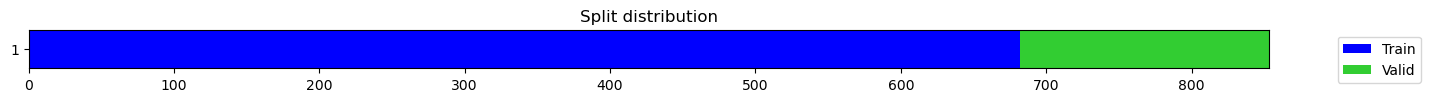

epoch,train_loss,valid_loss,mape,_rmse,mae,time
0,31283324.000000,51521848.000000,0.999855,7177.872070,7124.359863,00:17
1,31201416.000000,51481940.000000,0.999466,7175.091797,7121.592285,00:17
2,31043618.000000,50990596.000000,0.994507,7140.770508,7086.913086,00:17
3,30647848.000000,49855684.000000,0.982877,7060.855469,7005.858398,00:17
4,30116832.000000,48659472.000000,0.970258,6975.634277,6918.644043,00:17
5,29343338.000000,46118012.000000,0.943070,6791.024902,6730.095703,00:16
6,28259688.000000,44162696.000000,0.921665,6645.502441,6581.471680,00:17
7,26873570.000000,41537176.000000,0.891656,6444.934082,6374.526367,00:16
8,25182198.000000,38488236.000000,0.856058,6203.888672,6127.434570,00:16
9,23194452.000000,35072288.000000,0.813796,5922.186523,5835.501953,00:16


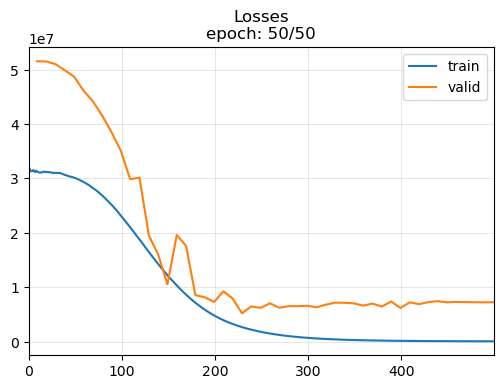

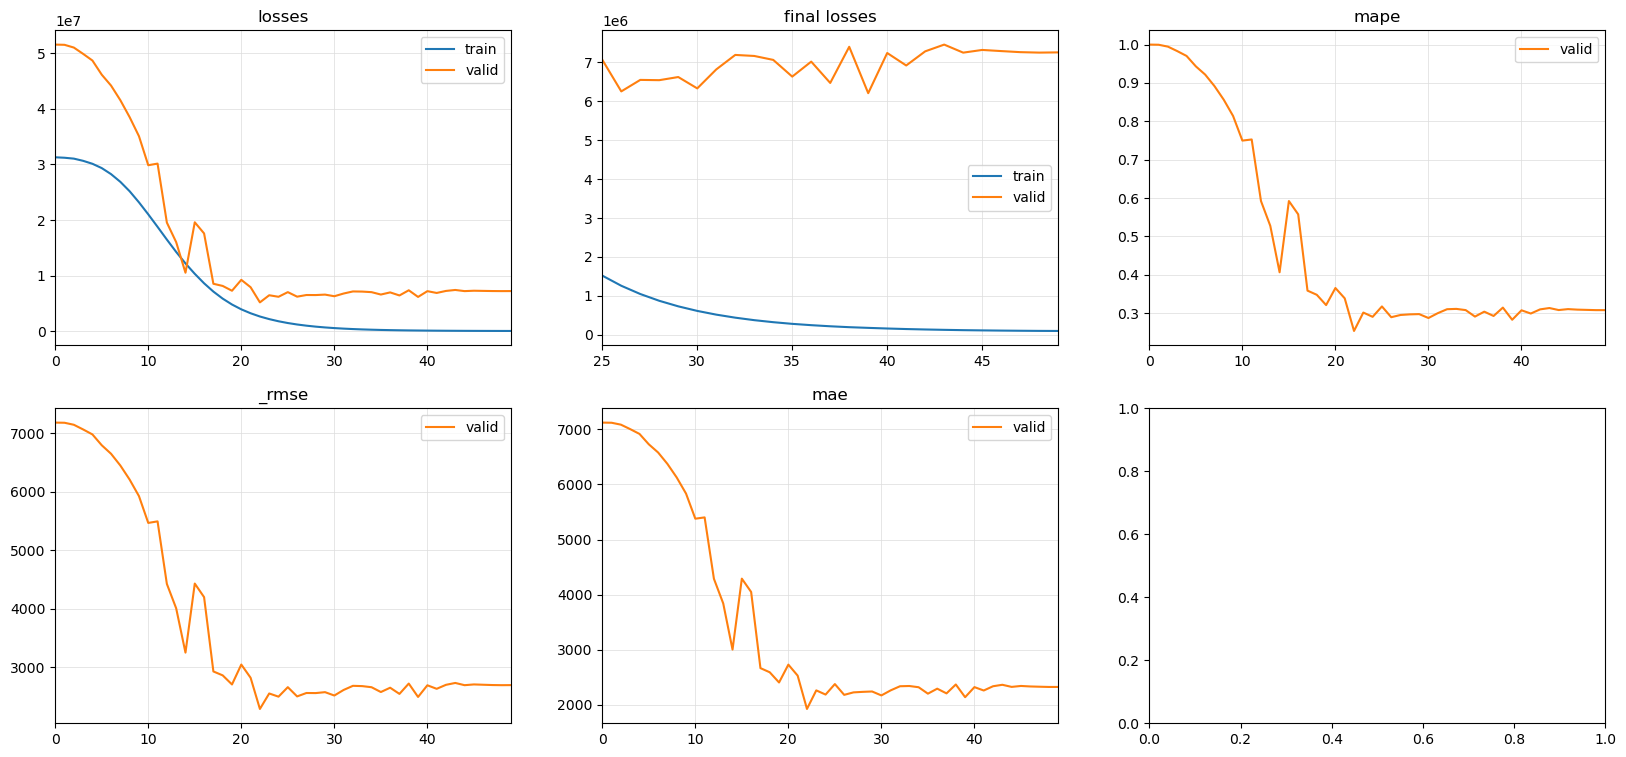

In [57]:
train("МСК", "keeping_actual", "/Users/tainella/Documents/MTC/МСК_хранение")

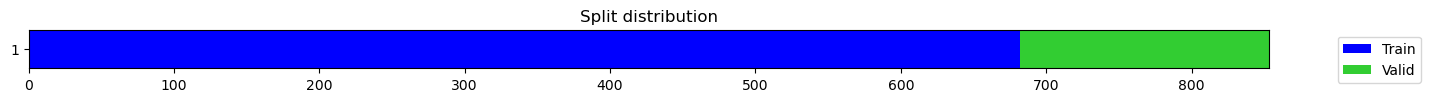

epoch,train_loss,valid_loss,mape,_rmse,mae,time
0,16171.183594,26435.224609,26332854.000000,162.589127,126.701561,00:16
1,14714.656250,25413.865234,117910856.000000,159.417267,124.469093,00:16
2,12854.397461,14766.903320,1410064384.000000,121.519157,98.001419,00:17
3,11492.663086,18034.257812,918803520.000000,134.291687,107.251350,00:17
4,10682.689453,13434.396484,1675435520.000000,115.906837,93.609955,00:17
5,10077.472656,17640.468750,989726976.000000,132.817429,105.140526,00:17
6,9647.442383,14039.732422,1550059008.000000,118.489372,95.287926,00:17
7,9301.753906,14750.588867,1426656384.000000,121.452003,97.163284,00:17
8,9016.490234,13082.268555,1645719680.000000,114.377747,91.702484,00:17
9,8617.278320,10795.982422,1068566976.000000,103.903717,77.925163,00:17


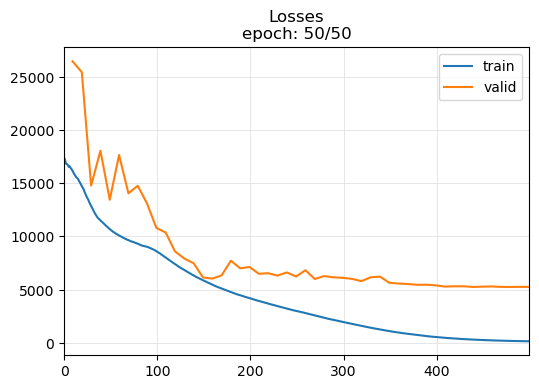

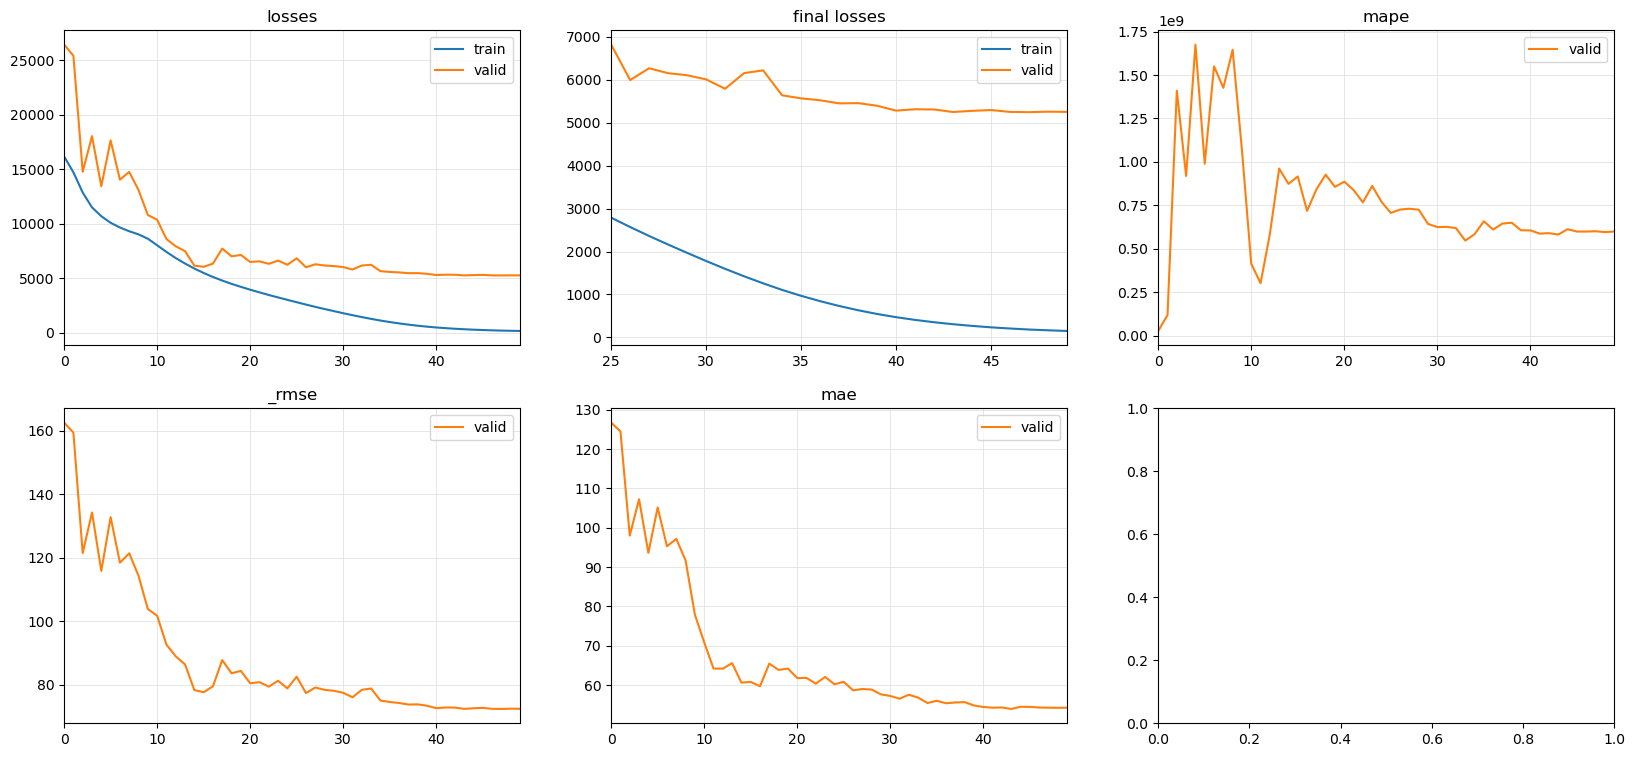

In [58]:
train("МСК", "processing_actual", "/Users/tainella/Documents/MTC/МСК_обработка")

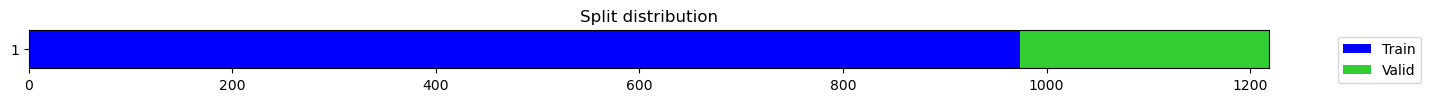

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [63]:
train("СЗ", "keeping_actual", "/Users/tainella/Documents/MTC/СЗ_хранение")

In [ ]:
train("СЗ", "processing_actual", "/Users/tainella/Documents/MTC/СЗ_обработка")

### Предсказания на 6 месяцев вперед для выдачи решения

In [ ]:
def predict_and_save(name, skl_type, path_load):
    '''
        name = ['МСК', 'Урал', 'СЗ'] - имя склада
        skl_type = ['keeping_actual' , 'processing_actual'] - тип 
    '''
    learn = load_learner(path_load)
    